In [1]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 6.0 MB/s eta 0:00:0000:0100:01m


In [43]:
import os
os.listdir("data/")[:5]

['receipt_00043.png',
 'receipt_00055.png',
 'receipt_00017.png',
 'receipt_00041.png',
 'receipt_00046.png']

In [1]:
import cv2

In [81]:
img = cv2.imread("data/receipt_00011.png")

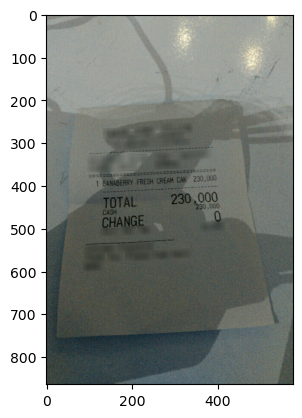

In [82]:
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

### Line detector

https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

Gaussian blur is first applied.

In [83]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

Edge detection using Canny.

In [84]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

Then, use HoughLinesP to get the lines. You can adjust the parameters for better performance.

In [85]:
import numpy as np

In [103]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

for line in lines:
    for x1, y1, x2, y2 in line:
        angle = math.atan((y1 - y2) / (x2 - x1))
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

# Draw the lines on the image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

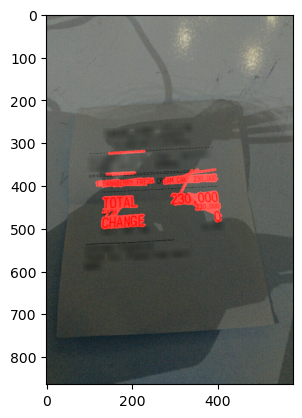

In [104]:
plt.imshow(lines_edges)
plt.show()

In [88]:
lines[0]

array([[345, 444, 400, 430]], dtype=int32)

Image de travers si beaucoup de lignes avec un angle légèrement positif ou négatif. 
On peut prendre angle = moyenne de ces faibles angles puis tilt l'image en conséquence.

In [89]:
import math
def get_skew_angles(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    angles = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = math.atan((y1 - y2) / (x2 - x1))
            angles.append(angle)
    return angles

In [90]:
angles = get_skew_angles(img=img)

Text(0.5, 0, 'Data')

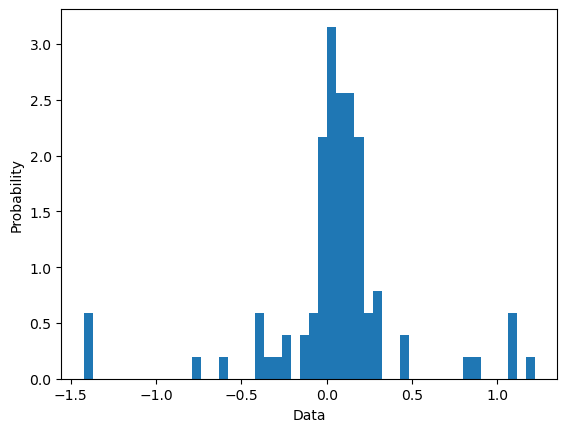

In [91]:
plt.hist(angles, density=True, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [92]:
filtered_angles = [angle for angle in angles if abs(angle) < 0.25]

In [93]:
len(angles)

96

In [94]:
len(filtered_angles)

74

In [95]:
skew_angle = sum(filtered_angles) / len(filtered_angles)

In [96]:
skew_angle_in_degrees = skew_angle * 180 / math.pi

In [97]:
skew_angle_in_degrees

3.860860910962449

Rotation

In [98]:
# Rotate the image around its center
def rotate_image(image, angle: float):
    new_image = image.copy()
    (h, w) = new_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    new_image = cv2.warpAffine(new_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return new_image

In [99]:
deskewed_image = rotate_image(img, -skew_angle_in_degrees)

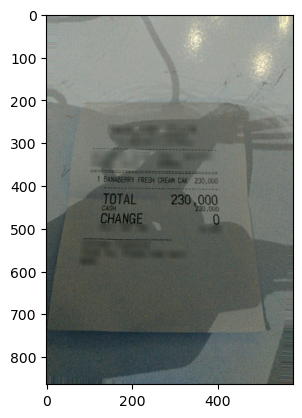

In [100]:
plt.imshow(deskewed_image)
plt.show()